In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import glob 
from common.trajectory_analysis import Trajectory
from common.util import DelayLine
import scipy
from scipy.stats import pearsonr
import common.circstats as cs

In [2]:
def interpolate(ts, xs, new_ts):
    x_spline = scipy.interpolate.UnivariateSpline(ts, xs, k=3, s=0)
    new_xs = x_spline(new_ts)
    return new_xs

In [3]:
def distance(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5


pxtomm = 1/10.8

freqs = [0.27, 0.40, 0.54, 0.67, 0.81, 0.94, 1.07, 1.21, 1.34]
filename_speeds = [     3,    5,    7,    9,   11,   13,   15,   17,   19]
centerx, centery = center = 87.99, 51.66 # mm
radiusx, radiusy = radius = 34.0, 19.3   # mm
radius_ratio = radiusx / radiusy


In [4]:
class Data:

    def __init__(self, filename, dt=0.005, cut = None, smooth_t=None, smooth_c=None):
        self.dt = dt
        d = json.load(open(filename))
        self.filename = filename
        # raw
        self.tts = np.array(d["ts"]) - d["ts"][0]  # time, zeroed
        self.txs = np.array(d["tx"]) * pxtomm       # target x
        self.tys = np.array(d["ty"]) * pxtomm       # tatget y
        self.cxs = np.array(d["cx"]) * pxtomm       # cursor x
        self.cys = np.array(d["cy"]) * pxtomm       # cursor y
        
        self.tr  = Trajectory(self.txs, self.tys, self.tts, dt = dt, cut=cut, smooth = smooth_t)
        
        # smoothed cursor/pen data
        self.cr  = Trajectory(self.cxs, self.cys, self.tts, dt = dt, cut=cut, smooth = smooth_c)      
         
        self.tph = np.unwrap(np.arctan2(self.tr.y - centery, self.tr.x - centerx))
        self.cph = np.unwrap(np.arctan2(self.cr.y - centery, self.cr.x - centerx))
        self.dph = self.cph - self.tph

        r =  np.array([distance((self.cr.x[i], self.cr.y[i]), center) for i in range(len(self.cr.t))])
        r_ratio = radiusx / radiusy
        self.rc =  r *  np.sqrt(np.cos(self.cph)**2 + (r_ratio*np.sin(self.cph))**2)
        self.ds = radiusx - self.rc
        self.a = np.repeat(radiusx, len(self.ds))
    
        spi = filename.find("speed")
        fn_speed = int(filename[spi+5:spi+8])
        fri = filename_speeds.index(fn_speed)
        self.freq = freqs[fri]


In [5]:
dt = 0.005

files = glob.glob("..//data1//*.txt")
data = [Data(f, smooth_c = 10, cut=[2, 1], dt=dt) for f in files]

In [6]:
colors = {
    "target": "#882255",
    "cursor": "#44AA99",
    "virtual":"#547dde",
    "model" : "#f6914b"
}


In [7]:
slows = [d for d in data if "speed 3" in d.filename]
fasts = [d for d in data if "speed 19" in d.filename]

In [8]:
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 15}
matplotlib.rc('font', **font)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


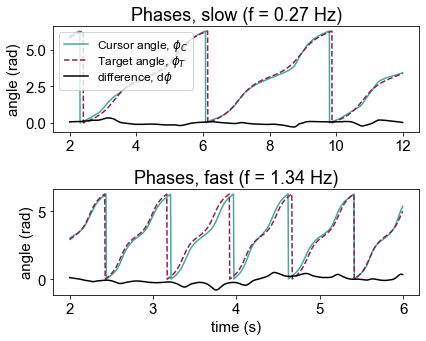

In [9]:
plt.figure(figsize=[6, 5])
plt.subplot(211)
plt.title("Phases, slow (f = 0.27 Hz)")
d = slows[1]
t = d.tr.t
take = np.arange(int(0/dt), int(10/dt))
plt.plot(t[take], d.cph[take]% (2*np.pi), color = colors["cursor"], label=r"Cursor angle, $\phi_C$")
plt.plot(t[take], d.tph[take]% (2*np.pi), "--", color = colors["target"], label=r"Target angle, $\phi_T$")
plt.plot(t[take], d.dph[take], color="black", label=r"difference, d$\phi$")
plt.ylabel("angle (rad)")
plt.legend(loc="upper left", prop={'size': 12}, labelspacing=0)

plt.subplot(212)
plt.title("Phases, fast (f = 1.34 Hz)")
d = fasts[1]
t = d.tr.t
take = np.arange(int(0/dt), int(4/dt))
plt.plot(t[take], d.cph[take]% (2*np.pi), color = colors["cursor"], label=r"$\phi_C$")
plt.plot(t[take], d.tph[take]% (2*np.pi), "--", color = colors["target"], label=r"$\phi_T$")
plt.plot(t[take], d.dph[take], color="black", label=r"d$\phi$")


plt.ylabel("angle (rad)")
plt.xlabel("time (s)")
plt.tight_layout()
#plt.ylim(-1, 20)
#plt.legend()
plt.savefig("..//figures/Figure 4, Phases.eps", format="eps", bbox_inches="tight")
plt.show()


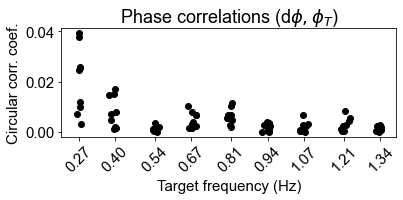

In [10]:
## Circular correlations

cc = cs.corrcc

plt.figure(figsize=[6, 2])

phase_corrs = [abs(cc(d.dph, d.tph)) for d in data ]
freqs_t =  [ d.freq + np.random.normal(loc=0, scale = 0.01) for d in data ]

plt.ylabel("Circular corr. coef.")

plt.title(r"Phase correlations (d$\phi,  \phi_T$)")
plt.scatter(freqs_t, phase_corrs, color="black")

plt.xticks(freqs, rotation=45)
plt.xlabel("Target frequency (Hz)")
plt.savefig("..//figures/Figure 4, Ellipses circular corrlation.eps", format="eps", bbox_inches="tight")
plt.show()


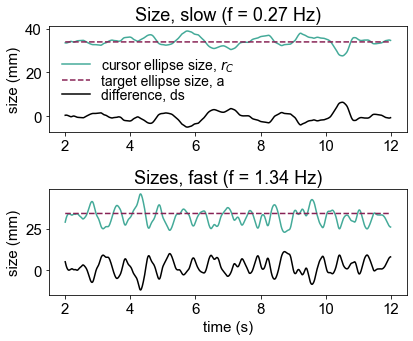

In [11]:
plt.figure(figsize=[6, 5])
plt.subplot(211)
plt.title("Size, slow (f = 0.27 Hz)")
d = slows[0]
t = d.tr.t
take = np.arange(int(0/dt), int(10/dt))
plt.plot(t[take], d.rc[take], color = colors["cursor"], label=r"cursor ellipse size, $r_C$")
plt.plot(t[take], d.a[take], "--", color = colors["target"], label=r"target ellipse size, a")
plt.plot(t[take], d.ds[take], color="black", label=r"difference, ds")
plt.ylabel("size (mm)")
plt.legend(loc="center left", prop={'size': 14}, labelspacing=0, frameon=False)

plt.subplot(212)
plt.title("Sizes, fast (f = 1.34 Hz)")
d = fasts[0]
t = d.tr.t
take = np.arange(int(0/dt), int(10/dt))
plt.plot(t[take], d.rc[take], color = colors["cursor"], label=r"cursor ellipse size $r_C$")
plt.plot(t[take], d.a[take], "--", color = colors["target"], label=r"target ellipse size, a")
plt.plot(t[take], d.ds[take], color="black", label=r"difference, ds")
plt.ylabel("size (mm)")
plt.xlabel("time (s)")
plt.tight_layout()
#plt.ylim(-1, 20)
#plt.legend()
plt.savefig("..//figures/Figure 4, Ellipses sizes.eps", format="eps", bbox_inches="tight")
plt.show()